In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras import layers, models

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

# Normalize
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Labels for supervised contrastive loss need to be one-hot
y_train_onehot = tf.one_hot(y_train, depth=10)
y_test_onehot = tf.one_hot(y_test, depth=10)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
class L2Normalize(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

def create_encoder():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = L2Normalize()(x)  # ✅ fixed: wrapped normalization
    return tf.keras.Model(inputs, x, name="encoder")


In [8]:
# Custom Supervised Contrastive Loss
class SupConLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def call(self, labels, features):
        labels = tf.argmax(labels, axis=1)
        features = tf.math.l2_normalize(features, axis=1)
        similarity_matrix = tf.matmul(features, features, transpose_b=True) / self.temperature
        logits_mask = tf.cast(tf.not_equal(tf.expand_dims(labels, 1), tf.expand_dims(labels, 0)), tf.float32)
        logits_mask = 1 - logits_mask

        exp_logits = tf.exp(similarity_matrix) * logits_mask
        log_prob = similarity_matrix - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-9)

        mean_log_prob_pos = tf.reduce_sum(log_prob * logits_mask, axis=1) / tf.reduce_sum(logits_mask, axis=1)
        loss = -mean_log_prob_pos
        return tf.reduce_mean(loss)

In [9]:
# Contrastive Model

class SupConModel(tf.keras.Model):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            features = self.encoder(x, training=True)
            loss = self.loss_fn(y, features)
        grads = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [11]:
# Train contrastive model
encoder = create_encoder()
model = SupConModel(encoder)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss_fn=SupConLoss())
model.fit(x_train, y_train_onehot, batch_size=256, epochs=12)

Epoch 1/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 120s 607ms/step - loss: 3.2616
Epoch 2/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 141s 601ms/step - loss: 3.2604
Epoch 3/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 600ms/step - loss: 3.2592
Epoch 4/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 603ms/step - loss: 3.2616
Epoch 5/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 141s 599ms/step - loss: 3.2597
Epoch 6/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 601ms/step - loss: 3.2607
Epoch 7/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 601ms/step - loss: 3.2586
Epoch 8/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 600ms/step - loss: 3.2613
Epoch 9/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 599ms/step - loss: 3.2601
Epoch 10/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 599ms/step - loss: 3.2596
Epoch 11/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 117s 599ms/step - loss: 3.2601
Epoch 12/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 600ms/step - loss: 3.2599


In [12]:
# Train Regular Classifier
def create_classifier():
    base = create_encoder()
    inputs = tf.keras.Input(shape=(32, 32, 3))
    features = base(inputs)
    outputs = tf.keras.layers.Dense(12, activation='softmax')(features)
    return tf.keras.Model(inputs, outputs)

clf = create_classifier()
clf.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
clf.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 83ms/step - accuracy: 0.3049 - loss: 1.9195 - val_accuracy: 0.4771 - val_loss: 1.4252
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.4921 - loss: 1.4062 - val_accuracy: 0.5415 - val_loss: 1.2817
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 84ms/step - accuracy: 0.5495 - loss: 1.2552 - val_accuracy: 0.5853 - val_loss: 1.1711
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 82ms/step - accuracy: 0.5867 - loss: 1.1615 - val_accuracy: 0.6069 - val_loss: 1.1264
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 83ms/step - accuracy: 0.6147 - loss: 1.0875 - val_accuracy: 0.6122 - val_loss: 1.0901


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step


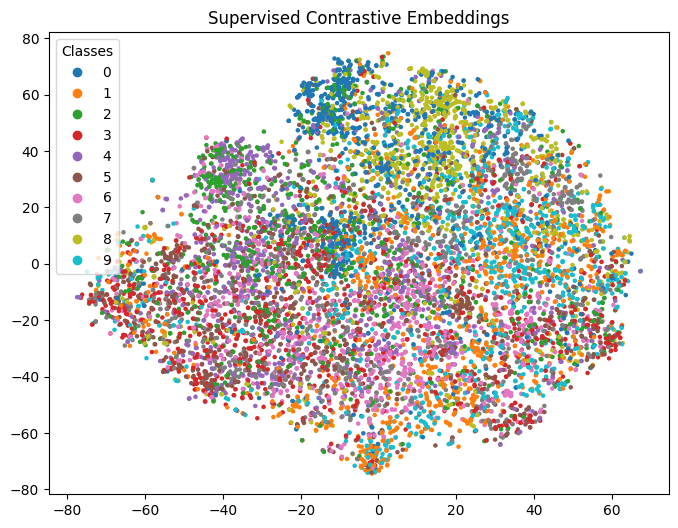

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step


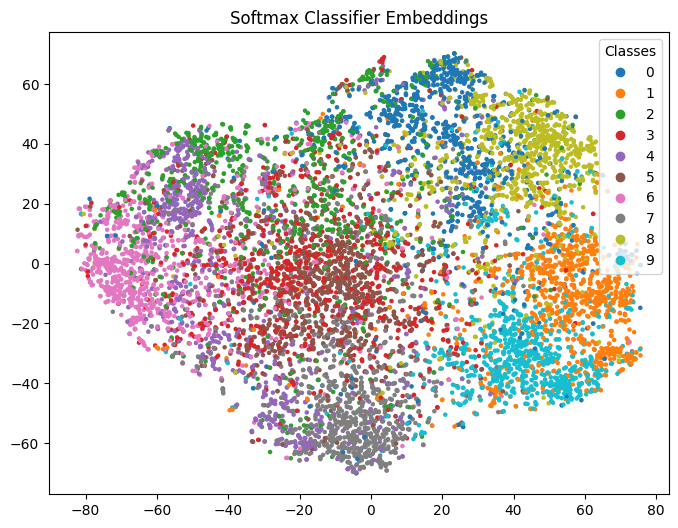

In [13]:
# Visualize Embeddings
def plot_tsne(model, x, y, title):
    features = model.predict(x, batch_size=256)
    tsne = TSNE(n_components=2, random_state=60)
    tsne_results = tsne.fit_transform(features)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y, cmap="tab10", s=5)
    plt.legend(*scatter.legend_elements(), title="Classes", loc="best")
    plt.title(title)
    plt.show()

plot_tsne(model.encoder, x_test, y_test, "Supervised Contrastive Embeddings")
plot_tsne(clf.get_layer("encoder"), x_test, y_test, "Softmax Classifier Embeddings")


In [15]:
# Nearest Centroid Classification + Confusion Matrix
def get_class_centroids(encoder, x_data, y_data, num_classes=10):
    features = encoder.predict(x_data, batch_size=256)
    centroids = np.zeros((num_classes, features.shape[1]))
    for i in range(num_classes):
        centroids[i] = np.mean(features[y_data == i], axis=0)
    return centroids

def predict_by_centroid(encoder, x_data, centroids):
    features = encoder.predict(x_data, batch_size=256)
    distances = np.linalg.norm(features[:, None] - centroids[None, :], axis=2)
    return np.argmin(distances, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.grid(False)
    plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step


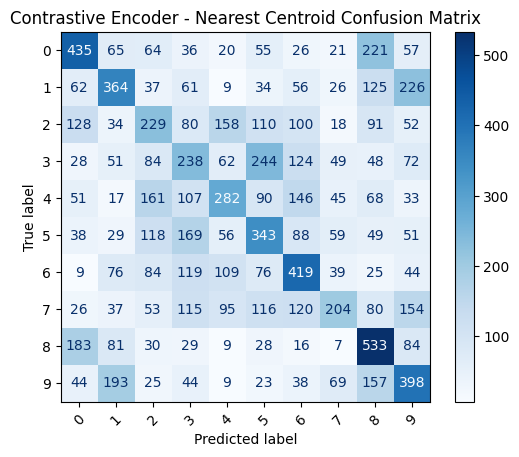

In [16]:
# Contrastive encoder evaluation
contrastive_centroids = get_class_centroids(model.encoder, x_test, y_test)
contrastive_preds = predict_by_centroid(model.encoder, x_test, contrastive_centroids)
plot_conf_matrix(y_test, contrastive_preds, "Contrastive Encoder - Nearest Centroid Confusion Matrix")


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step


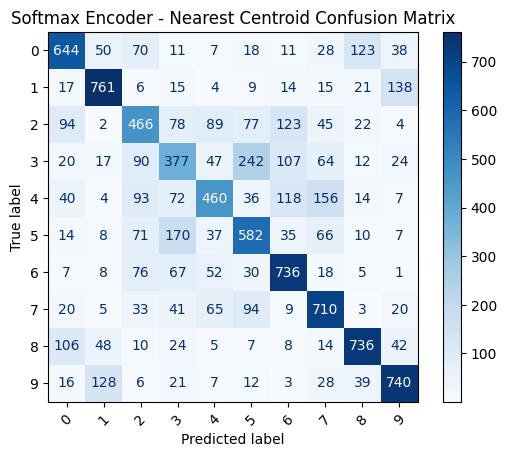

In [17]:
# Softmax encoder evaluation
softmax_encoder = clf.get_layer("encoder")
softmax_centroids = get_class_centroids(softmax_encoder, x_test, y_test)
softmax_preds = predict_by_centroid(softmax_encoder, x_test, softmax_centroids)
plot_conf_matrix(y_test, softmax_preds, "Softmax Encoder - Nearest Centroid Confusion Matrix")


These plots show us:

- How well each encoder clusters features in embedding space

- Whether the contrastive encoder leads to tighter, more class-distinct clusters